In [1]:
import torch
from torch.autograd import Variable, grad
from pyro.distributions.torch.gamma import Gamma
from rejection_gamma import RejectionStandardGamma, ShapeAugmentedStandardGamma

import numpy as np
import scipy.stats
from matplotlib import pyplot
%matplotlib inline

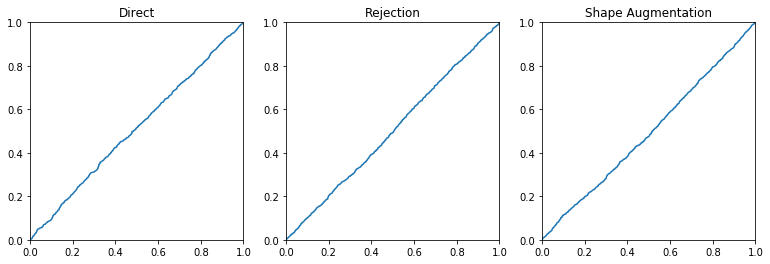

In [2]:
alpha0 = 1.0
alpha = Variable(alpha0 * torch.ones(1000), requires_grad=True)
beta = Variable(torch.ones(1000))
x = Gamma(alpha, beta).sample().data.numpy()
y = RejectionStandardGamma(alpha).sample().data.numpy()
z = ShapeAugmentedStandardGamma(alpha, 1).sample().data.numpy()
x.sort(); y.sort(); z.sort()
rank = (np.arange(len(alpha)) + 0.5) / len(alpha)
fig, axes = pyplot.subplots(1, 3, figsize=(13,4))
fig.patch.set_color('white')
for ax, sample, name in zip(axes, [x, y, z], ['Direct', 'Rejection', 'Shape Augmentation']):
    ax.plot(rank, scipy.stats.gamma(alpha0).cdf(sample))
    ax.set_title(name)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
pyplot.show()

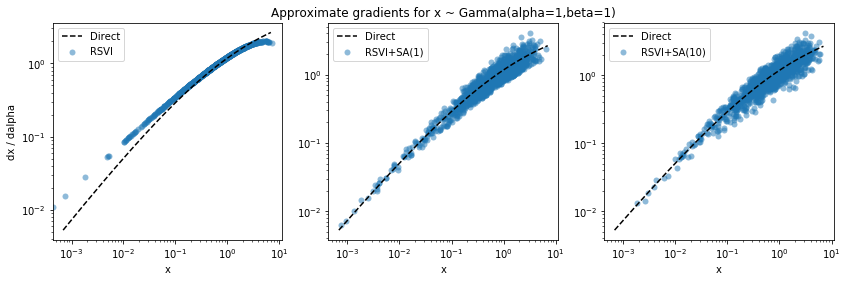

In [3]:
samples = {
    'Direct': Gamma(alpha, beta).sample(),
    'RSVI': RejectionStandardGamma(alpha).sample(),
    'RSVI+SA(1)': ShapeAugmentedStandardGamma(alpha, 1).sample(),
    'RSVI+SA(10)': ShapeAugmentedStandardGamma(alpha, 10).sample(),
}
x_dx = {}
for name, x in samples.items():
    dx, = grad([x.sum()], [alpha], retain_graph=True)
    x, ind = x.data.sort()
    x = x.numpy()
    dx = dx.data[ind].numpy()
    x_dx[name] = x, dx
    
fig, axes = pyplot.subplots(1, 3, figsize=(14,4))
fig.patch.set_color('white')
for ax, name in zip(axes, ['RSVI', 'RSVI+SA(1)', 'RSVI+SA(10)']):
    x, dx = x_dx['Direct']
    ax.plot(x, dx, 'k--', label='Direct')
    x, dx = x_dx[name]
    ax.scatter(x, dx, label=name, alpha=0.5, lw=0)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_xscale('log')
    ax.set_yscale('log')
axes[0].set_ylabel('dx / dalpha')
axes[1].set_title('Approximate gradients for x ~ Gamma(alpha={:0.2g},beta=1)'.format(alpha0))
pyplot.show()

TODO add boosting and shape augmentation.